In [3]:
import sys
!{sys.executable} -m pip install shap


  Using cached shap-0.50.0-cp314-cp314-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.63.0b1-cp314-cp314-macosx_10_15_universal2.whl.metadata (2.9 kB)
  Using cached llvmlite-0.46.0b1-cp314-cp314-macosx_11_0_universal2.whl.metadata (4.9 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
Using cached shap-0.50.0-cp314-cp314-macosx_11_0_arm64.whl (555 kB)
Using cached llvmlite-0.46.0b1-cp314-cp314-macosx_11_0_universal2.whl (37.3 MB)
Using cached numba-0.63.0b1-cp314-cp314-macosx_10_15_universal2.whl (2.8 MB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [5]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
import pandas as pd

# Charger les données préparées
data_fe = pd.read_csv("../data/data_fe.csv")

# Séparer variables explicatives et cible
X = data_fe.drop("TARGET", axis=1)
y = data_fe["TARGET"]


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Chargement du modèle final
best_model = joblib.load("models/credit_scoring_model.pkl")
print(X_test.shape)


(61503, 229)


In [ ]:
from sklearn.pipeline import Pipeline
# 1. On "ouvre" le pipeline pour prendre le modèle
model_final = best_model.named_steps['classifier']

# 2. On prépare les données (on applique l'Imputer et le Scaler du pipeline)
# On crée un pipeline de transformation qui contient tout sauf le classifier
data_preprocessor = Pipeline(steps=best_model.steps[:-1])
X_test_transformed = data_preprocessor.transform(X_test)

# 3. Création de l'explainer spécifique aux arbres
explainer = shap.TreeExplainer(model_final)

# 4. Calcul des SHAP values
# On utilise les données transformées
shap_values = explainer.shap_values(X_test_transformed)



**Explication globale du modèle**

Quelles variables influencent le plus les prédictions ?

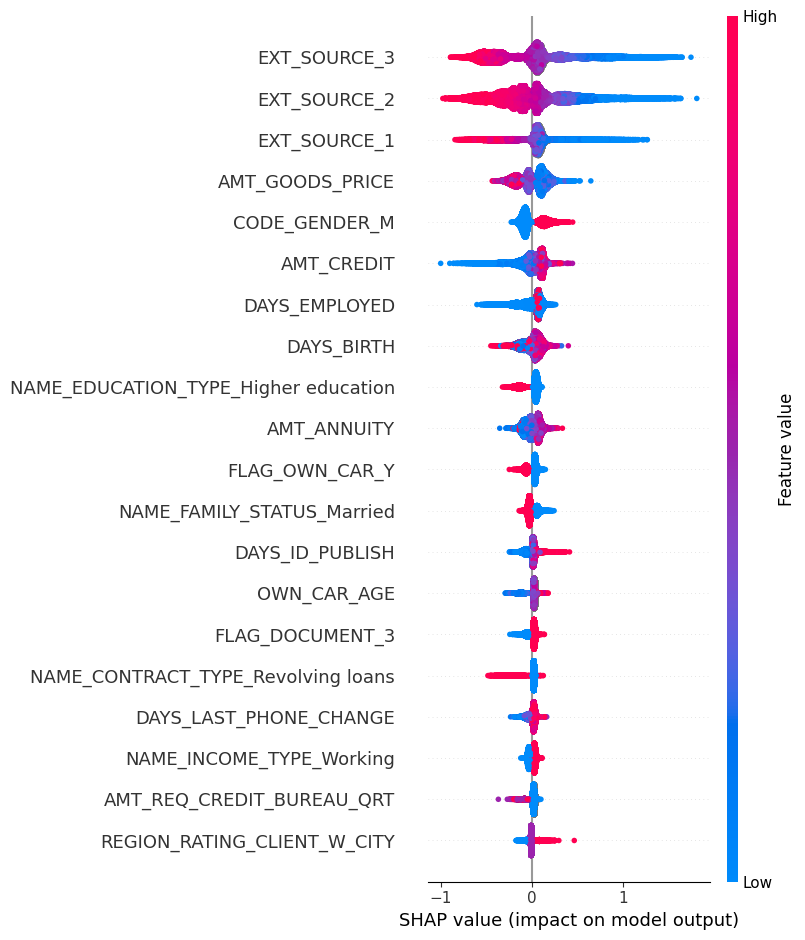

In [17]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

**Interprétation :**

rouge → augmente le risque

bleu → diminue le risque

position horizontale → importance

In [18]:
# Explication d’un client précis

# Choix d’un client
client_index = 0
client = X_test.iloc[[client_index]]


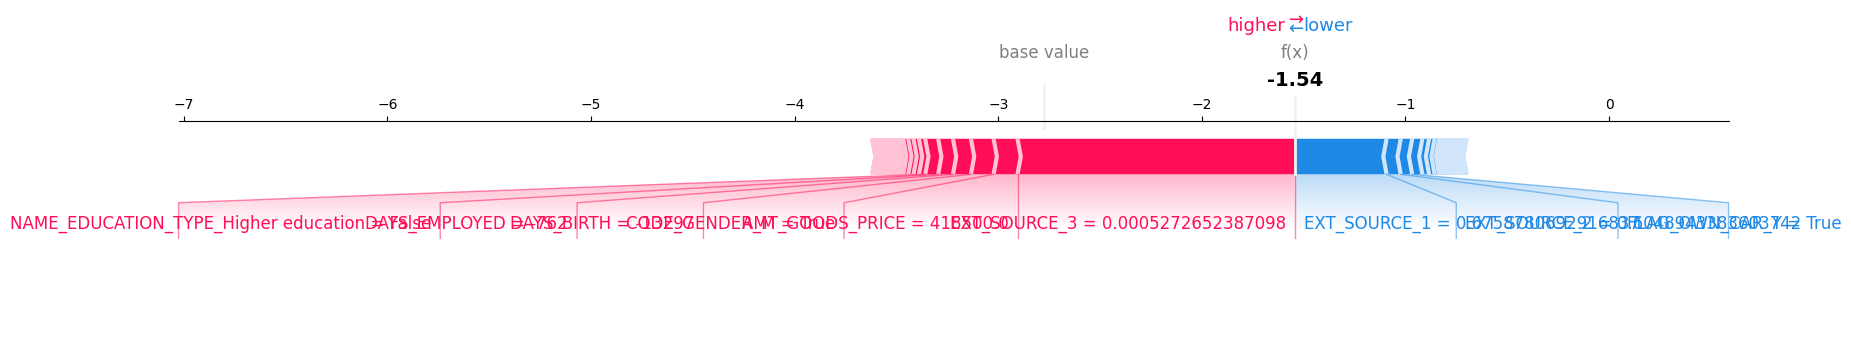

In [ ]:
# 1. Chargement le moteur JavaScript
shap.initjs()

# 2. Calculer la valeur SHAP pour le client
# Si ton modèle fait de la classification (ex: continents), 
# shap_values renvoie une liste. On prend l'index [1] pour la classe positive.
shap_values_all = explainer.shap_values(client)

# Sélectionner la valeur selon le type de modèle (RandomForest ou autre)
if isinstance(shap_values_all, list):
    # Pour les classifieurs multi-classes, on choisit une classe 
    s_val = shap_values_all[1]
    e_val = explainer.expected_value[1]
else:
    # Pour les modèles binaires ou de régression
    s_val = shap_values_all
    e_val = explainer.expected_value

# 3. Affichage du Force Plot
shap.force_plot(
    e_val, 
    s_val, 
    client,
    matplotlib=True # 
)

variables à droite → augmentent le risque

variables à gauche → réduisent le risque

In [34]:
print(type(explainer.expected_value))
print(np.array(explainer.expected_value).shape)


<class 'numpy.ndarray'>
(1,)


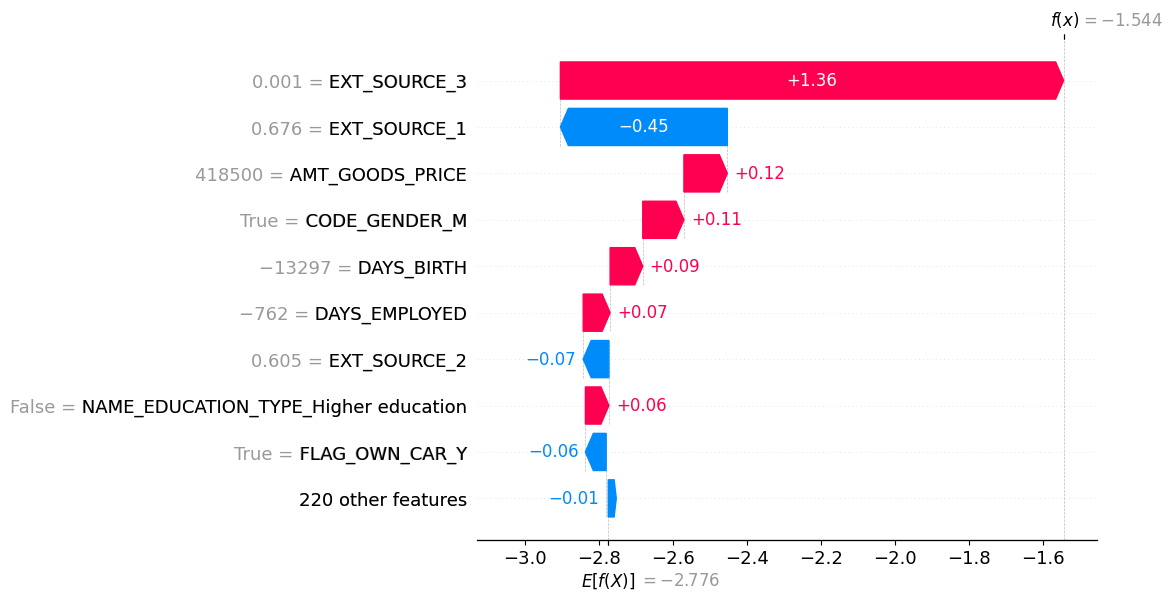

In [ ]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_value_client[0],
        base_values=explainer.expected_value[0],  # 
        data=client.iloc[0],
        feature_names=X_test.columns
    )
)



## Interprétation locale

La prédiction pour ce client spécifique est expliquée par la contribution individuelle de chaque variable au score final du modèle.

Certaines caractéristiques **augmentent la probabilité de défaut**, en particulier **EXT_SOURCE_3**, qui a l’impact le plus fort et tire fortement la prédiction vers le risque. D’autres variables comme **AMT_GOODS_PRICE**, **le genre (CODE_GENDER_M)**, **l’âge (DAYS_BIRTH)** et **l’ancienneté professionnelle (DAYS_EMPLOYED)** contribuent également à accroître ce risque, mais de manière plus modérée.

À l’inverse, certaines caractéristiques **diminuent la probabilité de défaut**, notamment **EXT_SOURCE_1**, **EXT_SOURCE_2** et le fait de **posséder une voiture (FLAG_OWN_CAR_Y)**, qui compensent partiellement les effets négatifs des autres variables.

Cette approche permet de fournir une justification claire et transparente de la décision d’octroi de crédit, en montrant précisément quelles variables ont influencé la prédiction et dans quel sens.